# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [421]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Initial Data Observations

In [245]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [199]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [200]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [201]:
transcript.head(30)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [202]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [203]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [204]:
len(transcript)

306534

In [205]:
len(profile)

17000

In [206]:
len(portfolio)

10

In [207]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [208]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

### Investigate and Clean Portfolio Dataset

In [209]:
#Edit portfolio dataset
#https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
channels = portfolio['channels'].str.join(sep='*').str.get_dummies(sep='*')
offer_type = pd.get_dummies(portfolio["offer_type"])
offer_type

portfolio_new = pd.concat([portfolio, channels, offer_type], axis=1, sort=False)
portfolio_new.drop(['channels', 'offer_type'],axis=1)
col = portfolio_new.pop('id')
portfolio_new.insert(0, 'id', col)
portfolio_new

,id,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,1,1,0,1,0,1,0


In [210]:
#Edit profile dataset
profile['age'].unique()
profile[profile['age']==118]

#Remove rows where age is 118 since it is unrealistic and missing gender values

profile_new = profile.drop(profile[profile['age']==118].index)
profile_new.isnull().sum()
#profile_new

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Text(0.5, 1.0, 'Customers by Gender')

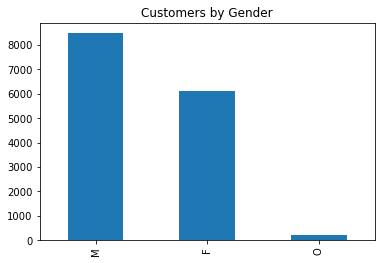

In [270]:
#Breakdown of customers by gender
profile_new.gender.value_counts().plot.bar().set_title("Customers by Gender")

Text(0.5, 0, 'Age')

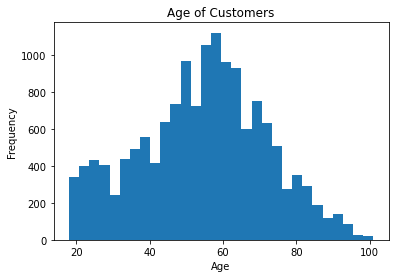

In [276]:
#Breakdown of customers by age
profile_new['age'].plot(kind='hist', bins=30, title='Age of Customers').set_xlabel("Age")

Text(0.5, 0, 'Income')

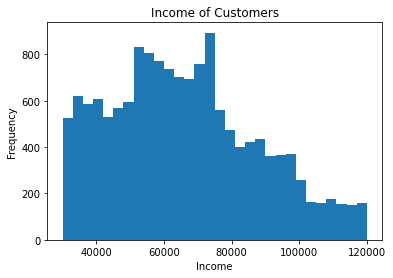

In [275]:
#Breakdown of customers by income groups
profile_new['income'].plot(kind='hist', bins=30, title='Income of Customers').set_xlabel("Income")

### Investigate and Clean Transcript Dataset

In [211]:
#Edit transcript dataset
np.unique(transcript.event)

#Convert event column into dummies
event_dummies = pd.get_dummies(transcript.event)

array(['offer completed', 'offer received', 'offer viewed', 'transaction'],
      dtype=object)

In [213]:
#Some values in the value column are offer id, offer_id and amounts. Need to separate them out

offer_list = []
amount = []
for i in range(len(transcript.value)):
    offer_list.append(list(transcript.value[i].keys())[0])
    amount.append(list(transcript.value[i].values())[0])
    
#Initialize columns
transcript['amount_cat']= amount
transcript['offer_id_cat']= offer_list

transcript['offer_id_cat'].replace({'offer id':'offer_id'}, inplace=True)
    

In [214]:
transcript

,person,event,value,time,amount_cat,offer_id_cat
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,offer_id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,offer_id
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1.59,amount
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9.53,amount
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3.61,amount
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3.53,amount


In [215]:
offer_id = []
amount_clean = []

for i in range(len(transcript.value)):
    if transcript.offer_id_cat[i] == "offer_id":
         offer_id.append(transcript.amount_cat[i])
    else: 
         offer_id.append('None')

for i in range(len(transcript.value)):
    if transcript.offer_id_cat[i] == "offer_id":
         amount_clean.append(0)
    else: 
         amount_clean.append(transcript.amount_cat[i]) 
            
transcript['amount'] = amount_clean       
transcript['offer_id'] = offer_id


In [216]:
transcript_new = pd.concat([transcript,event_dummies],axis=1).drop(columns = {"event","value","amount_cat","offer_id_cat"})
transcript_new

,person,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,None,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,None,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,3.61,None,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,None,0,0,0,1


### Combine all dataframes together to form 1 big dataframe for analysis

In [229]:
#Combine all dataframes together

transcript_portfolio_new = transcript_new.merge(portfolio_new, how='left', left_on='offer_id', right_on='id').drop(columns={'id',"channels"})
transcript_portfolio_new

,person,time,amount,offer_id,offer completed,offer received,offer viewed,transaction,reward,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,None,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,None,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,3.61,None,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,None,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [435]:
#Merge final dataframe so we get transaction on all profiles 

df = transcript_portfolio_new.merge(profile_new,left_on='person', right_on='id').drop(columns='id').fillna(0)
df

,person,time,amount,offer_id,offer completed,offer received,offer viewed,transaction,reward,difficulty,...,mobile,social,web,bogo,discount,informational,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,...,1.0,0.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5.0,5.0,...,1.0,0.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,None,0,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,132,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5.0,5.0,...,1.0,0.0,1.0,1.0,0.0,0.0,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,None,0,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,F,75,20170509,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,504,0.00,3f207df678b143eea3cee63160fa8bed,0,0,1,0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,M,47,20171013,94000.0
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,10.0,10.0,...,1.0,1.0,1.0,1.0,0.0,0.0,M,47,20171013,94000.0
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1,0,10.0,10.0,...,1.0,1.0,1.0,1.0,0.0,0.0,M,47,20171013,94000.0
272760,3045af4e98794a04a5542d3eac939b1f,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,10.0,10.0,...,1.0,1.0,1.0,1.0,0.0,0.0,F,58,20161020,78000.0


### Exploratory Data Analysis

In [436]:
#Exploratory Data Analysis
df['age_ranges'] = pd.cut(df["age"], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 102])
df['income_ranges'] = pd.cut(df["income"], bins=[20000,40000,60000,80000,100000,120000])
#Look at data where transactions had offers completed
#Look at offer type of successful offer completions, channels, difficulty, duration and reward
#print(df.loc[df['offer completed']==1,'amount'].sum())


$0 is spent when transactions do not take place, which makes sense.

In [335]:
#Find offer completion rates compared to offer receipts
no_reward_transaction_avg = df.loc[df['transaction']==1, 'amount'].mean()
print("Average spend for transactions with no offer: {0:.2f}".format(no_reward_transaction_avg))

offer_received = df['offer received'].sum()
offer_completed = df['offer completed'].sum()
offer_viewed = df['offer viewed'].sum()

percent_completed = offer_completed/(offer_received+offer_viewed+offer_completed)*100

print("Total number of offers received: {}".format(offer_received))
print("Total number of offers viewed: {}".format(offer_viewed)) 
print("Total number of completed offers: {}".format(offer_completed))
print("Percentage of completed offers after receiving an offer: {0:.2f}%".format(percent_completed))

offer_received_difficulty  = df.loc[df['offer received'] == 1, 'difficulty'].mean()
offer_completed_difficulty = df.loc[df['offer completed'] == 1, 'difficulty'].mean()
offer_viewed_difficulty = df.loc[df['offer viewed'] == 1, 'difficulty'].mean()

print("Average minimum spend to complete offer for offers received: {0:.2f}".format(offer_received_difficulty))
print("Average minimum spend to complete offer for offers viewed: {0:.2f}".format(offer_viewed_difficulty)) 
print("Average minimum spend to complete offer for completed offers: {0:.2f}".format(offer_completed_difficulty))

offer_received_reward  = df.loc[df['offer received'] == 1, 'reward'].mean()
offer_completed_reward = df.loc[df['offer completed'] == 1, 'reward'].mean()
offer_viewed_reward = df.loc[df['offer viewed'] == 1, 'reward'].mean()

print("Average minimum reward for offers received: {0:.2f}".format(offer_received_reward))
print("Average minimum reward for offers viewed: {0:.2f}".format(offer_viewed_reward)) 
print("Average minimum reward for completed offers: {0:.2f}".format(offer_completed_reward))


Average spend for transactions with no offer: 14.00
Total number of offers received: 66501
Total number of offers viewed: 49860
Total number of completed offers: 32444
Percentage of completed offers after receiving an offer: 21.80%
Average minimum spend to complete offer for offers received: 7.71
Average minimum spend to complete offer for offers viewed: 7.20
Average minimum spend to complete offer for completed offers: 9.31
Average minimum reward for offers received: 4.20
Average minimum reward for offers viewed: 4.44
Average minimum reward for completed offers: 4.95


Text(0.5, 1.0, 'Offer Completions by Gender')

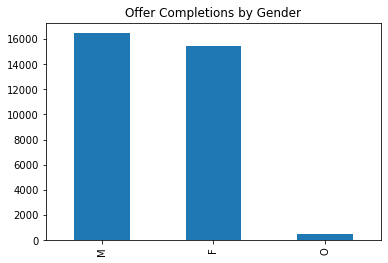

In [318]:
#Dive deeper into the demographics of those who completed offers
#Breakdown of customers by gender
df.loc[df['offer completed'] == 1,"gender"].value_counts().plot.bar().set_title("Offer Completions by Gender")


Text(0.5, 0, 'Age')

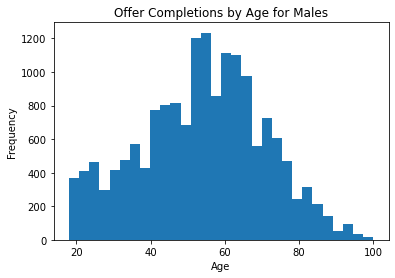

In [333]:
#Breakdown of customers by age for Males
df.loc[(df['offer completed'] == 1) & (df['gender'] == "M"),"age"].plot(kind='hist', bins=30, title='Offer Completions by Age for Males').set_xlabel("Age")

Text(0.5, 0, 'Age')

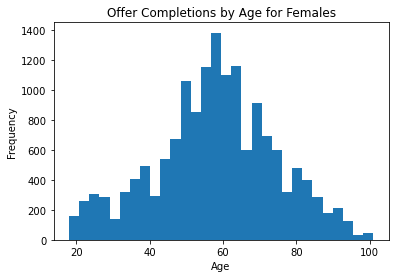

In [326]:
#Breakdown of customers by age for Females
df.loc[(df['offer completed'] == 1) & (df['gender'] == "F"),"age"].plot(kind='hist', bins=30, title='Offer Completions by Age for Females').set_xlabel("Age")

Text(0.5, 0, 'Income')


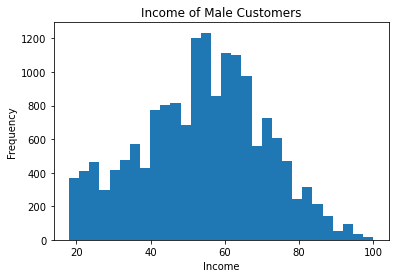

In [331]:
#Breakdown of customers by income groups
print(df.loc[(df['offer completed'] == 1) & (df['gender'] == "M"),"age"].plot(kind='hist', bins=30, title='Income of Male Customers').set_xlabel("Income"))

Text(0.5, 0, 'Income')


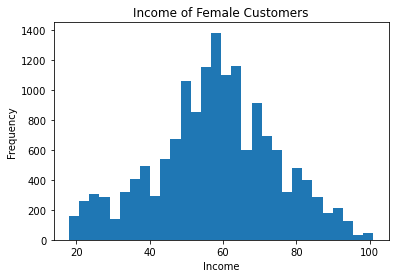

In [332]:
print(df.loc[(df['offer completed'] == 1) & (df['gender'] == "F"),"age"].plot(kind='hist', bins=30, title='Income of Female Customers').set_xlabel("Income"))

#### There is no discernable difference in the income groups and age of males and females who complete offers.

In [337]:
#Analyze type of completed offers (bogo, discount, informational)

bogo = df.loc[df['offer completed'] == 1, 'bogo'].sum()
discount  = df.loc[df['offer completed'] == 1, 'discount'].sum()
informational = df.loc[df['offer completed'] == 1, 'informational'].sum()

perc_bogo = bogo/offer_completed*100
perc_discount = discount/offer_completed*100
perc_info = informational/offer_completed*100

print("Percentage of completed offers for bogo: {0:.2f}%".format(perc_bogo)) 
print("Percentage of completed offers for discount: {0:.2f}%".format(perc_discount))
print("Percentage of completed offers for informational: {0:.2f}%".format(perc_info))

Percentage of completed offers for bogo: 47.03%
Percentage of completed offers for discount: 52.97%
Percentage of completed offers for informational: 0.00%


#### Interestingly, informational offers did not lead to any completed offers

In [349]:
completed_bogo_difficulty  = df.loc[(df['offer completed'] == 1) & (df['bogo'] == 1), 'difficulty'].mean()
completed_discount_difficulty = df.loc[(df['offer completed'] == 1) & (df['discount'] == 1), 'difficulty'].mean()
completed_informational_difficulty = df.loc[(df['offer completed'] == 1) & (df['informational'] == 1), 'difficulty'].mean()

print("Average minimum spend for completed bogo offers: {0:.2f}".format(completed_bogo_difficulty))
print("Average minimum spend for completed discount offers: {0:.2f}".format(completed_discount_difficulty)) 
print("Average minimum spend for completed informational offers: {0:.2f}".format(completed_informational_difficulty))

incomplete_bogo_difficulty  = df.loc[(df['offer completed'] == 0) & (df['bogo'] == 1), 'difficulty'].mean()
incomplete_discount_difficulty = df.loc[(df['offer completed'] == 0) & (df['discount'] == 1), 'difficulty'].mean()
incompleted_informational_difficulty = df.loc[(df['offer completed'] == 0) & (df['informational'] == 1), 'difficulty'].mean()

print("Average minimum spend for incomplete bogo offers: {0:.2f}".format(incomplete_bogo_difficulty))
print("Average minimum spend for incomplete discount offers: {0:.2f}".format(incomplete_discount_difficulty)) 
print("Average minimum spend for incomplete informational offers: {0:.2f}".format(incompleted_informational_difficulty))


completed_bogo_reward  = df.loc[(df['offer completed'] == 1) & (df['bogo'] == 1), 'reward'].mean()
completed_discount_reward = df.loc[(df['offer completed'] == 1) & (df['discount'] == 1), 'reward'].mean()
completed_informational_reward = df.loc[(df['offer completed'] == 1) & (df['informational'] == 1), 'reward'].mean()

print("Average reward for completed bogo offers: {0:.2f}".format(completed_bogo_reward))
print("Average reward for completed discount offers: {0:.2f}".format(completed_discount_reward)) 
print("Average reward for completed informational offers: {0:.2f}".format(completed_informational_reward))


incomplete_bogo_reward  = df.loc[(df['offer completed'] == 0) & (df['bogo'] == 1), 'reward'].mean()
incomplete_discount_reward = df.loc[(df['offer completed'] == 0) & (df['discount'] == 1), 'reward'].mean()
incomplete_informational_reward = df.loc[(df['offer completed'] == 0) & (df['informational'] == 1), 'reward'].mean()

print("Average reward for incomplete bogo offers: {0:.2f}".format(incomplete_bogo_reward))
print("Average reward for incomplete discount offers: {0:.2f}".format(incomplete_discount_reward)) 
print("Average reward for incomplete informational offers: {0:.2f}".format(incomplete_informational_reward))

Average minimum spend for completed bogo offers: 7.28
Average minimum spend for completed discount offers: 11.12
Average minimum spend for completed informational offers: nan
Average minimum spend for incomplete bogo offers: 7.63
Average minimum spend for incomplete discount offers: 11.11
Average minimum spend for incomplete informational offers: 0.00
Average reward for completed bogo offers: 7.28
Average reward for completed discount offers: 2.88
Average reward for completed informational offers: nan
Average reward for incomplete bogo offers: 7.63
Average reward for incomplete discount offers: 2.88
Average reward for incomplete informational offers: 0.00


Some interesting observations. Although discount offers form most of the completed offers, it has the highest spend requirements and the lowest rewards. It also does not matter whether the orders are completed or not, the bogo and discount offers are equal, suggesting the reward size does not impact whether someone responds to an offer.

Perhaps different demographics are targeted for different types of offers.

In [356]:
#See if duration of offer has an impact on bogo or discount offers being completed

bogo_time_complete = df.loc[(df['offer completed'] == 1) & (df['bogo'] == 1), 'time'].mean()
discount_time_complete  = df.loc[(df['offer completed'] == 1) & (df['discount'] == 1), 'time'].mean()

bogo_time_incomplete = df.loc[(df['offer completed'] == 0) & (df['bogo'] == 1), 'time'].mean()
discount_time_incomplete = df.loc[(df['offer completed'] == 0) & (df['discount'] == 1), 'time'].mean()

print("Average time for completed bogo offers: {0:.2f}".format(bogo_time_complete))
print("Average time for completed discount offers: {0:.2f}".format(discount_time_complete)) 
print("Average time for incomplete bogo offers: {0:.2f}".format(bogo_time_incomplete))
print("Average time for incomplete discount offers: {0:.2f}".format(discount_time_incomplete)) 

Average time for completed bogo offers: 391.71
Average time for completed discount offers: 406.63
Average time for incomplete bogo offers: 342.15
Average time for incomplete discount offers: 341.46


#### Time does play a factor in whether an offer is completed. Completed offers were around for a greater length of time.

In [403]:
df.groupby(['gender'])['amount'].mean()

gender
F    7.636493
M    5.426751
O    6.637255
Name: amount, dtype: float64

#### Females on average spend more than males

In [404]:
df.groupby(['gender'])['offer completed'].mean()

gender
F    0.136842
M    0.105761
O    0.126165
Name: offer completed, dtype: float64

In [398]:
#Check if income ranges 

df.groupby(['income_ranges','age_ranges'])['amount'].mean()

income_ranges     age_ranges
(20000, 40000]    (10, 20]       2.774843
                  (20, 30]       3.519353
                  (30, 40]       3.290682
                  (40, 50]       3.196894
                  (50, 60]       2.905506
                  (60, 70]       3.344358
                  (70, 80]       3.515567
                  (80, 90]       3.255985
                  (90, 100]      3.730264
                  (100, 102]          NaN
(40000, 60000]    (10, 20]       3.829233
                  (20, 30]       4.326662
                  (30, 40]       4.541578
                  (40, 50]       4.745538
                  (50, 60]       4.838413
                  (60, 70]       4.390813
                  (70, 80]       4.589444
                  (80, 90]       4.661869
                  (90, 100]      4.126472
                  (100, 102]     7.621228
(60000, 80000]    (10, 20]       5.302296
                  (20, 30]       5.393302
                  (30, 40]       6.510612
     

In [392]:
#Check if income ranges affect offers at starbucks

df.groupby(['income_ranges','age_ranges'])['offer completed'].mean()

income_ranges     age_ranges
(20000, 40000]    (10, 20]      0.071653
                  (20, 30]      0.079644
                  (30, 40]      0.084366
                  (40, 50]      0.079844
                  (50, 60]      0.076423
                  (60, 70]      0.082160
                  (70, 80]      0.090303
                  (80, 90]      0.089298
                  (90, 100]     0.111562
                  (100, 102]         NaN
(40000, 60000]    (10, 20]      0.083097
                  (20, 30]      0.088797
                  (30, 40]      0.099477
                  (40, 50]      0.106029
                  (50, 60]      0.105033
                  (60, 70]      0.100633
                  (70, 80]      0.102886
                  (80, 90]      0.107196
                  (90, 100]     0.098121
                  (100, 102]    0.105263
(60000, 80000]    (10, 20]      0.090859
                  (20, 30]      0.098732
                  (30, 40]      0.108303
                  (40, 50]  

In [394]:
df.groupby(['income_ranges','age_ranges'])['difficulty'].mean()

income_ranges     age_ranges
(20000, 40000]    (10, 20]      3.401151
                  (20, 30]      3.540096
                  (30, 40]      3.676458
                  (40, 50]      3.673483
                  (50, 60]      3.785379
                  (60, 70]      3.601721
                  (70, 80]      3.839394
                  (80, 90]      3.420586
                  (90, 100]     4.030426
                  (100, 102]         NaN
(40000, 60000]    (10, 20]      3.515980
                  (20, 30]      3.726499
                  (30, 40]      3.839432
                  (40, 50]      4.149317
                  (50, 60]      4.087054
                  (60, 70]      4.049015
                  (70, 80]      4.108684
                  (80, 90]      4.019840
                  (90, 100]     4.125261
                  (100, 102]    3.070175
(60000, 80000]    (10, 20]      3.762665
                  (20, 30]      3.811037
                  (30, 40]      3.940095
                  (40, 50]  

In [395]:
df.groupby(['income_ranges','age_ranges'])['reward'].mean()

income_ranges     age_ranges
(20000, 40000]    (10, 20]      2.061715
                  (20, 30]      2.042632
                  (30, 40]      2.126827
                  (40, 50]      2.171373
                  (50, 60]      2.110006
                  (60, 70]      2.075587
                  (70, 80]      2.106667
                  (80, 90]      1.966599
                  (90, 100]     2.022312
                  (100, 102]         NaN
(40000, 60000]    (10, 20]      2.172585
                  (20, 30]      2.096982
                  (30, 40]      2.153771
                  (40, 50]      2.330971
                  (50, 60]      2.279023
                  (60, 70]      2.283193
                  (70, 80]      2.344795
                  (80, 90]      2.327510
                  (90, 100]     2.538622
                  (100, 102]    0.824561
(60000, 80000]    (10, 20]      2.178414
                  (20, 30]      2.169086
                  (30, 40]      2.192622
                  (40, 50]  

In [384]:
df.groupby(df['income_ranges'])['bogo'].mean()

income_ranges
(20000, 40000]      0.205512
(40000, 60000]      0.217434
(60000, 80000]      0.236463
(80000, 100000]     0.272657
(100000, 120000]    0.278031
Name: bogo, dtype: float64

In [383]:
df.groupby(df['income_ranges'])['discount'].mean()

income_ranges
(20000, 40000]      0.194821
(40000, 60000]      0.212628
(60000, 80000]      0.234518
(80000, 100000]     0.265851
(100000, 120000]    0.265829
Name: discount, dtype: float64

Not surprisingly, those with higher incomes spend more. They also get offers with higher minimum spending but get higher rewards too and are more likely to complete an offer. The type of discount does not vary much by income range. Age also has an influence on the likelihood on completing an offer. However, that relationship breaks down for those with high incomes.

Text(0.5, 0, 'Age')

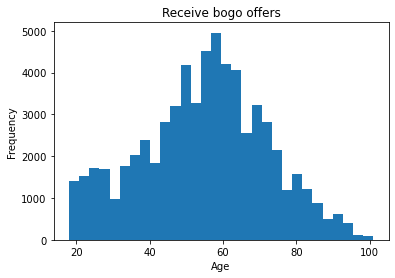

In [371]:
#Breakdown of customers who receive discounts
df.loc[(df['bogo'] == 1),"age"].plot(kind='hist', bins=30, title='Receive bogo offers').set_xlabel("Age")

Text(0.5, 0, 'Age')

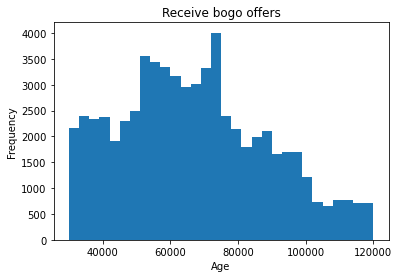

In [370]:
df.loc[(df['bogo'] == 1),"income"].plot(kind='hist', bins=30, title='Receive bogo offers').set_xlabel("Age")

Text(0.5, 0, 'Age')

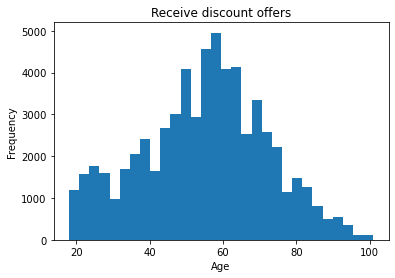

In [367]:
df.loc[(df['discount'] == 1),"age"].plot(kind='hist', bins=30, title='Receive discount offers').set_xlabel("Age")

Text(0.5, 0, 'Age')

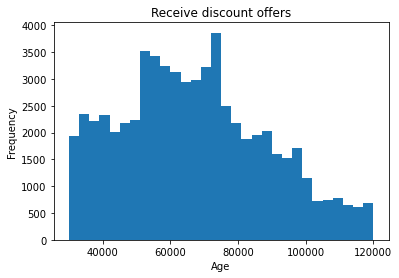

In [369]:
df.loc[(df['discount'] == 1),"income"].plot(kind='hist', bins=30, title='Receive discount offers').set_xlabel("Age")

Doesn't appear to be a big deviation in demographics for offers compared to the average starbucks customer profile

## Initial Summary of Findings:

1. Higher income and age influence offer completion and spending amount.
2. Duration of the offer influences offer completion rate
3. Discounts had the greatest offer completion rate followed by bogo but had the lowest reward rate.
4. Females complete offers more often than males and even though on average females spend much more than males, there is no distinction in offer targeting between male and female by age and income.

From this, if we wanted to maximize the chance an offer is completed, it is best to target the highest spenders. That means targeting older females with the largest incomes using discount offers over bogo offers that have long durations (~400 days). 


To better optimize offer completion and targeting, more work will need to be done to maximize the extra spend a customer makes by completing an offer.

## Build Model to predict likelihood of completing offer

In [508]:
#Create data set for model. We want to predict features that best predict likelihood of completing offer
gender = pd.get_dummies(df['gender'])
df1 = pd.concat([df,gender],axis=1, sort=False)
df_model = df1[df1['offer_id']!= 'None']
Y = df_model['offer completed']
df_model = df_model.drop(['amount','person', 'offer received', 'offer viewed','offer_type','offer_id','transaction','became_member_on','offer completed','gender','age_ranges','income_ranges'], axis=1)
X = df_model

In [509]:
#Modeling

from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [510]:
X_train

,time,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,F,M,O
252185,408,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,56,60000.0,1,0,0
96154,336,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,53,96000.0,1,0,0
144290,336,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39,35000.0,1,0,0
121709,174,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,38,87000.0,1,0,0
27666,336,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,50,71000.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218653,414,3.0,7.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,70,69000.0,0,1,0
188093,174,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,56,59000.0,1,0,0
243308,504,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,66,55000.0,0,1,0
269501,504,3.0,7.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,49,56000.0,0,0,1


#### Building a Random Forest Classifier Predictive Model

In [511]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
classifier = RandomForestClassifier()
#Train the model
classifier.fit(X_train,y_train)
# predictions
y_pred = classifier.predict(X_test)


In [530]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[34264  4108]
 [ 7846  2888]]
0.7565674255691769
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     38372
           1       0.41      0.27      0.33     10734

    accuracy                           0.76     49106
   macro avg       0.61      0.58      0.59     49106
weighted avg       0.73      0.76      0.74     49106



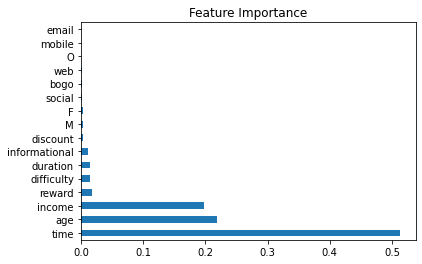

time             0.512437
reward           0.017091
difficulty       0.014586
duration         0.014179
email            0.000000
mobile           0.000384
social           0.002043
web              0.000954
bogo             0.001472
discount         0.002953
informational    0.010671
age              0.218807
income           0.198313
F                0.002579
M                0.002658
O                0.000871
dtype: float64


In [527]:
#Show the most important features
feat_importances = pd.Series(classifier.feature_importances_, index=df_model.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

print(feat_importances)

The model predicts with an accuracy of 75.7% and the most important features are time, age, and income. This validates my initial findings during my exploratory data analysis.

In [535]:
#Improve the model with hyperparameter tuning and cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
scorer = make_scorer(precision_score) #use precision_score for classification
param_grid = {'max_features':['auto', 'sqrt'], 
              'min_samples_leaf':[2,4,6,8,10],
              'min_samples_split':[2,4,6,8,10]} 
grid = GridSearchCV(classifier, param_grid, cv=3, scoring=scorer)
grid_fit = grid.fit(X_train, y_train)
y_pred = grid_fit.predict(X_test)

In [536]:
#Check model performance of optimized model
print(grid_fit.best_params_)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 6}
[[37041  1331]
 [ 8629  2105]]
0.7971734614914674
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     38372
           1       0.61      0.20      0.30     10734

    accuracy                           0.80     49106
   macro avg       0.71      0.58      0.59     49106
weighted avg       0.77      0.80      0.75     49106



Optimizing the model hyperparameters improves the model accuracy to 79.7% versus 75.7%

## Conclusion

Duration of offer, income of customer and age of customer are the biggest predictors of whether a customer completes an offer. The customer gender and the distribution method of the offer do not have any predictive power of whether a customer completes an offer.

From this, if we wanted to maximize the chance an offer is completed, it is best to target those with the largest incomes and older ages with offer durations that last a long time. 

To better optimize offer completion and targeting, more work will need to be done to maximize the extra spend a customer makes by completing an offer.